# TraitSimulation: Example Power Analysis

Authors: Sarah Ji, Chris German, Kenneth Lange, Janet Sinsheimer, Hua Zhou, Jin Zhou, Eric Sobel

In this notebook, we show a example downstream application of TraitSimulation as part of a larger software pipeline for a single simulation model. The details of all the model specifications can find the documentation [here](https://openmendel.github.io/TraitSimulation.jl/dev/). Operating within the OpenMendel universe brings potential advantages over the available software(s) when needed for downstream analysis or study design. 

We illustrate the example on simulated data under the Ordered Multinomial Model and present this example in three digestable steps: 
   1. Simulating genotypes and covariate values representative of study population.
   2. Create the OrderedMultinomialTrait model object and use it for simulation
   3. For each simulated trait, we perform a likelihood ratio test of the above hypothesis test and reject the null when the p-value falls below prespecified significance level. In our example, we define the power for the model is estimated as the proportion of 1000 tests rejecting the null at significance level α= 5×10−8.

Double check that you are using Julia version 1.0 or higher by checking the machine information

In [1]:
versioninfo()

Julia Version 1.5.2
Commit 539f3ce943 (2020-09-23 23:17 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


In [2]:
using Random, Plots, DataFrames, LinearAlgebra, DelimitedFiles
using SnpArrays, TraitSimulation, GLM, StatsBase, OrdinalMultinomialModels
Random.seed!(1234);

### `Create Simulated Design Matrix:`

#### Genetic Covariates:

Say for example, we have a study population of `n = 5000` people, where 51% are females, the mean age is 45 years with a standard deviation of 8 years and we are interested in studying the effect of the causal snp with a predetermined minor allele frequency. To demonstrate usage, we use the minor allele frequency of the causal variant to simulate the SnpArray under Hardy Weinberg Equillibrium (HWE) with the `snparray_simulation` function as follows:
    
    
| Genotype | Plink/SnpArray |  
|:---:|:---:|  
| A1,A1 | 0x00 |  
| missing | 0x01 |
| A1,A2 | 0x02 |  
| A2,A2 | 0x03 |  
    

Given the specified minor allele frequency, `maf`, here `maf = [0.2]`, this function samples from the genotype vector under HWE and returns the compressed binary format under SnpArrays. Note if you give the function a vector of minor allele frequencies, specify `maf = [0.2, 0.25, 0.3]`, for each specified allele it will simulate a SnpArray under HWE and ouput them together.

In [3]:
n = 5000
maf_causal_snp = [0.2]
Simulated_SnpArray = snparray_simulation(maf_causal_snp, n)

5000×1 SnpArray:
 0x00
 0x02
 0x00
 0x00
 0x02
 0x02
 0x00
 0x00
 0x00
 0x00
 0x02
 0x00
 0x00
    ⋮
 0x00
 0x02
 0x00
 0x02
 0x00
 0x00
 0x03
 0x02
 0x00
 0x00
 0x02
 0x00

### convert
By default `convert` function translates genotypes according to the *additive* SNP model, which essentially counts the number of **A2** allele (0, 1 or 2) per genotype. Other SNP models are *dominant* and *recessive*, both in terms of the **A2** allele.

| Genotype | `SnpArray` | `model=ADDITIVE_MODEL` | `model=DOMINANT_MODEL` | `model=RECESSIVE_MODEL` |    
|:---:|:---:|:---:|:---:|:---:|  
| A1,A1 | 0x00 | 0 | 0 | 0 |  
| missing | 0x01 | NaN | NaN | NaN |
| A1,A2 | 0x02 | 1 | 1 | 0 |  
| A2,A2 | 0x03 | 2 | 1 | 1 |  

If desired, the user can decide to specify alternative model parameters found in the [SnpArrays](https://openmendel.github.io/SnpArrays.jl/latest/#convert-and-copyto!-1) documentation.

#### Non-Genetic Covariates:
For demo purposes we will standardize the age variable. Using the distributions package we can simulate the values for the non-genetic covariates and attach the causal locus as the last column in the design matrix. 

Now we concatenate the simulated causal locus, transformed to Float64, to the other covariates we want to control for in the study design.

In [4]:
pdf_sex = Bernoulli(0.51)
pdf_age = Normal(45, 8)

sex = rand(pdf_sex, n)
# simulate age under the specified pdf_age and standardize to be ~ N(0, 1)
age = zscore(rand(pdf_age, n))
locus = convert(Vector{Float64}, @view(Simulated_SnpArray[:, 1]))

X_new = [age sex locus]
DataFrame(X_new, [:age, :sex, :locus])

,age,sex,locus
,Float64,Float64,Float64
1,-0.25109,0.0,0.0
2,-1.45357,0.0,1.0
3,0.033503,0.0,0.0
4,-0.258144,0.0,0.0
5,1.34924,0.0,1.0
6,-0.904251,1.0,1.0
7,0.721633,1.0,0.0
8,0.857207,0.0,0.0
9,1.09343,1.0,0.0


In [5]:
θ = [1.0, 1.2, 1.4]
β_new = [1.0, 2.0, 10.0]
Ordinal_Model = OrderedMultinomialTrait(X_new, β_new, θ, LogitLink())

Ordinal Multinomial Model
  * number of fixed effects: 3
  * number of ordinal multinomial outcome categories: 4
  * link function: LogitLink
  * sample size: 5000

## `Power Calculation:`

We use the following function to generate the p-values for the simulated power example for the ordered multinomial regression model. We range effect sizes in the vector γs, which collects effect sizes from 0 to 1 in increments of 0.05. As expected, the power increases as the effect size increases. 
    

In [6]:
γs = collect(0.0:0.05:0.5)

11-element Array{Float64,1}:
 0.0
 0.05
 0.1
 0.15
 0.2
 0.25
 0.3
 0.35
 0.4
 0.45
 0.5

For each effect size in $\gamma_s,$ in each column we have the p-values obtained from testing the significance of the causal locus `nsim = 100` times under the ordinal multinomial model, `Ordinal_Model` and the `randomseed = 1234`. 

Each column of this matrix represents each of the detected effect sizes, and each row of this matrix represents each simulation for that effect size. The user feeds into the function the number of simulations, the vector of effect sizes, the TraitSimulation.jl model object, and the random seed.

In [7]:
nsim = 100
randomseed = 1234
simulated_pvalues = power_simulation(nsim, γs, Ordinal_Model, randomseed)

rename!(DataFrame(simulated_pvalues), [Symbol("γs = $(γs[i])") for i in 1:length(γs)])

,γs = 0.0,γs = 0.05,γs = 0.1,γs = 0.15,γs = 0.2,γs = 0.25,γs = 0.3
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.855951,0.0187605,0.267769,0.000544026,0.000178373,1.17209e-7
2,0.80426,0.375294,0.0254699,2.14406e-6,0.00694345,0.000401022,1.47274e-6
3,0.887353,0.466531,0.191279,0.000266644,0.000645622,0.00018249,5.30302e-9
4,0.870309,0.288366,0.481541,0.00240987,0.000497305,2.20692e-5,4.58894e-9
5,0.702148,0.442054,0.0227104,0.0901567,3.1852e-7,1.66813e-5,3.92366e-7
6,0.37725,0.897537,0.00448512,0.000546661,0.0290945,5.57953e-6,6.14809e-7
7,0.339944,0.143922,0.000355107,0.0111154,2.54036e-6,2.32e-5,2.22174e-7
8,0.556582,0.181974,0.0226719,0.00460977,0.00282481,1.219e-5,7.01034e-10
9,0.986037,0.139655,0.716812,0.00559746,0.00584378,2.15591e-7,9.11782e-7


Note that for GLMTrait objects, the `realistic_power_simulation` function makes the appropriate calls to the GLM.jl package to get the simulation p-values obtained from testing the significance of the causal locus using the Wald Test by default. However since the GLM.jl package has its limitations, we include additional power utilities that make the appropriate function calls to the [OrdinalMultinomialModels](https://openmendel.github.io/OrdinalMultinomialModels.jl/stable/#Syntax-1) to get the p-value obtained from testing the significance of the causal locus.

Now we find the power of each effect size in the user-specified γs vector at the specified alpha level of significance, and plot the trajectory using the Plots.jl package.

In [8]:
α = 5*10^-8
power_effectsize = power(simulated_pvalues, α)

11-element Array{Float64,1}:
 0.01
 0.0
 0.0
 0.01
 0.02
 0.12
 0.47
 0.72
 0.93
 1.0
 1.0

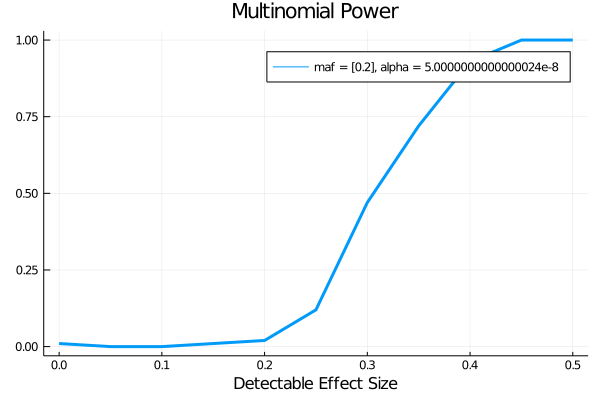

In [9]:
plot(γs, power_effectsize, title = "Multinomial Power", label = "maf = $maf_causal_snp, alpha = $α", lw = 3) # plot power
xlabel!("Detectable Effect Size")

### `Try it Yourself Exercises: `

With the remaining time we encourage you to play with the simulation models above. 

(1) If you change the significance level, α, what would happen to the plot of the power? How would the plot change with a smaller value of α ? 

(2) What if you change the sample size to be smaller than `n = 5000`? How does the power look as a function of the effect size when `n = 2500`? 

(3) What if we changed the minor allele frequency of the SNP of interest from `maf = 0.2` to say `maf = 0.3` ?

## Citations: 

[1] Lange K, Papp JC, Sinsheimer JS, Sripracha R, Zhou H, Sobel EM (2013) Mendel: The Swiss army knife of genetic analysis programs. Bioinformatics 29:1568-1570.`

[2] OPENMENDEL: a cooperative programming project for statistical genetics.
[Hum Genet. 2019 Mar 26. doi: 10.1007/s00439-019-02001-z](https://www.ncbi.nlm.nih.gov/pubmed/?term=OPENMENDEL).

[3] German, CA, Sinsheimer, JS, Klimentidis, YC, Zhou, H, Zhou, JJ. Ordered multinomial regression for genetic association analysis of ordinal phenotypes at Biobank scale. Genetic Epidemiology. 2019; 1– 13. https://doi.org/10.1002/gepi.22276

[4] Lange K, Boehnke M (1983) Extensions to pedigree analysis. IV. Covariance component models for multivariate traits. Amer J Med Genet 14:513:524

[5] Ji, SS, Lange, K, Sinsheimer, JS, Zhou, JJ, Zhou, H, Sobel, E. Modern Simulation Utilities for Genetic Analysis. BMC Bioinformatics. 2020; BINF-D-20-00690